In [82]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
# from model_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

# make sure `dot` is in the path
import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

# Define environments with different variance structures

We construct a Mouselab-MDP with a symmetric tree structure by specifying a branching structure
and a function `reward(depth) -> Distribution` that specifies the reward distribution for
the nodes at each depth. The ground truth for each environment is determined when the `MouselabEnv`
object is instantiated. We can keep the ground truth constant by specifying a `seed` value. Each
env will have a different ground truth, but if we call `envs = make_envs(n=10, seed=1)` multiple times,
`env[4]` will always have the same ground truth.

In [100]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_envs(cost=1.00, n=100, seed=None,variance_structure="constant_high",branching=[4,1,2]):
    if seed is not None:
        np.random.seed(seed)
    
    depth = len(branching)
    
    if variance_structure is "constant_high":
        sigmas = np.concatenate( (np.array([0]),20*np.ones(depth)))
    if variance_structure is "increasing":
        sigmas = [0, 2, 4, 20]
    if variance_structure is "decreasing":
        sigmas = [0,20,4,2]
    if variance_structure is "constant_low":
        sigmas = np.concatenate( (np.array([0]),1*np.ones(depth)))
        
    def reward(depth):
        if depth > 0:
            return Normal(0, sigmas[depth]).to_discrete(6)
        return 0.

    envs = [MouselabEnv.new_symmetric(branching, reward)
            for _ in range(n)]
    for env in envs:
        env.cost=-cost
    
    return envs

# Compute the LC policy for each of these environments

In [85]:
from mouselab_policy import MouselabPolicy

def lc_policy(x, normalize_voi=True):
    x = np.array(x)
    assert len(x) == 4, x
    voi = x[1:]
    if normalize_voi and voi.sum():
        voi /= voi.sum()
    # Note: an `is_term` feature is functionally equivalent to a `cost` feature
    # when all clicks have the same cost.
    weights = dict(zip(['is_term', 'voi_myopic', 'vpi_action', 'vpi_full'], x))
    return MouselabPolicy(weights)

In [73]:
from contexttimer import Timer

#COSTS = [0.1,0.5, 1, 1.25, 2, 4]
environments = ["constant_high","constant_low","increasing","decreasing"]

def avg_utility(x,train_envs):
    with Timer() as t:
        util = get_util(lc_policy(x), train_envs)
        xs =  np.array2string(np.array(x), 
                              formatter={'float_kind': lambda x: f'{x: 6.2f}'})
        print(f'{xs} -> {util:6.3f}  ({t.elapsed:2.1f} seconds)')
    return util

bounds = [
    (-30., 30.), # is_term
    (0., 1.),    # voi_myopic
    (0., 1.),    # vpi_action
    (0., 1.),    # vpi_full
]

from skopt import gp_minimize

try: 
    LC_policies
except NameError:
    LC_policies = dict()

cost = 1.00;
#for c in COSTS:
for env_type in environments:
    envs = make_envs(cost,10,None,env_type)#(cost=1.25, n=100, seed=None,variance_structure="constant_high"):
    def loss(x):
        return - avg_utility(x,envs) 
    
    result = gp_minimize(loss, bounds, n_calls=100, random_state=0)
    LC_policies[env_type] = lc_policy(result.x)


for env in environments:
    weights[env] = LC_policies[env].weights

np.save('data/weights_by_environment.npy',weights)



[  2.93   0.72   0.60   0.54] ->  9.560  (276.5 seconds)
[ -4.58   0.65   0.44   0.89] -> 12.127  (63.8 seconds)
[ 27.82   0.38   0.79   0.53] -> -1.980  (0.1 seconds)
[  4.08   0.93   0.07   0.09] ->  7.540  (12.8 seconds)
[-28.79   0.83   0.78   0.87] ->  5.080  (49.9 seconds)
[ 28.72   0.80   0.46   0.78] -> -1.980  (0.1 seconds)
[-22.90   0.64   0.14   0.94] -> 10.260  (25.4 seconds)
[  1.31   0.41   0.26   0.77] -> 10.820  (0.2 seconds)
[ -2.63   0.57   0.02   0.62] -> 12.507  (0.2 seconds)
[  6.73   0.62   0.94   0.68] -> 14.120  (9.5 seconds)
[ 12.08   0.29   0.69   1.00] ->  9.720  (0.1 seconds)
[  6.84   0.68   0.71   0.72] ->  9.960  (0.1 seconds)
[  2.73   0.00   1.00   1.00] ->  9.860  (302.1 seconds)
[-10.80   0.14   0.00   0.18] -> 11.860  (9.5 seconds)
[  6.69   0.61   0.96   0.68] ->  9.660  (0.1 seconds)
[-13.27   1.00   1.00   1.00] -> 11.480  (0.8 seconds)
[ -8.09   0.00   1.00   1.00] -> 12.460  (97.0 seconds)
[-15.69   0.00   0.00   0.00] ->  8.420  (0.1 seconds)
[

# Inspect LC policies

## Load LC policies

In [86]:
from agents import run_episode

#environments = ["constant_high","constant_low","increasing","decreasing"]
environments = ["constant_high","constant_low","increasing","decreasing"]

#load policies
try:
    LC_policies
except NameError:
    LC_policies = dict()

weights = np.load('data/weights_by_environment.npy').item()
for env_type in environments:
    x = [weights[env_type]['is_term'],weights[env_type]['voi_myopic'],weights[env_type]['vpi_action'],weights[env_type]['vpi_full']]
    LC_policies[env_type]= lc_policy(x)

## Inspect LC policy for the environment with outward-increasing variance

In [230]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"increasing")

leaf_nodes = [3,4,7,8,11,12,15,16]
nr_leafs = len(leaf_nodes)

all_leafs= []
not_all_leafs=[]
nr_leafs_inspected = []
nr_nonleafs_inspected = []
nongoal_before_goal = []

for env in envs:
    trace = run_episode(LC_policies["increasing"], env)
    all_leafs.append(np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    not_all_leafs.append(not np.all(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_leafs_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonleafs_inspected.append(len(trace['actions'][:-1])- nr_leafs_inspected[-1])
    is_goal = np.in1d(trace['actions'][:-1],leaf_nodes)
    if all_leafs[-1]:
        nongoal_before_goal.append(False)
    else:
        first_nongoal = np.where(is_goal == False)
        nongoal_before_goal.append(first_nongoal[0][0]<nr_leafs) 

Fraction of trials in which only goals were inspected: 0.862
Fraction of trials in which a non-goal was inspected before all goals had been inspected: 0.0
Avg. number of leafs inspected when non-leafs were inspected: 8.0
Avg. number of non-leafs inspected when any nonleafs were inspected: 3.9782608695652173
Example sequence: 
[15, 4, 7, 17]


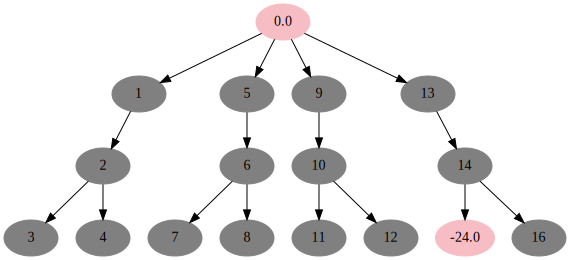

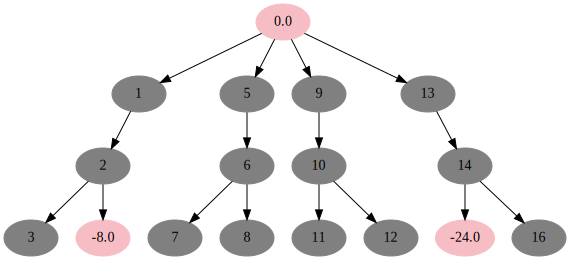

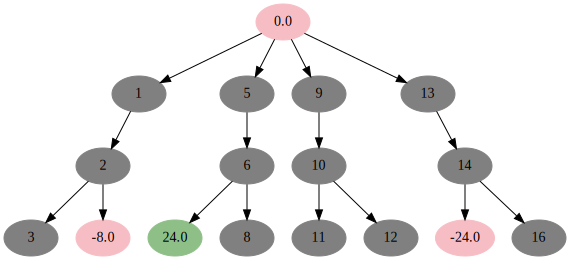

[12, 3, 8, 11, 4, 15, 7, 17]


In [231]:
print("Fraction of trials in which only goals were inspected: {}".format(np.mean(all_leafs)))
print("Fraction of trials in which a non-goal was inspected before all goals had been inspected: {}".format(np.mean(nongoal_before_goal)))

all_leafs_array = np.array(all_leafs)
nr_leafs_array = np.array(nr_leafs_inspected)
nr_nonleafs_array = np.array(nr_nonleafs_inspected)
np.mean(nr_leafs_array[~all_leafs_array])

print("Avg. number of leafs inspected when non-leafs were inspected: {}".format(np.mean(nr_leafs_array[~all_leafs_array])))
print("Avg. number of non-leafs inspected when any nonleafs were inspected: {}".format(np.mean(nr_nonleafs_array[~all_leafs_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["increasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

## Inspect Policy for environment with decreasing variance

In [233]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"decreasing")

leaf_nodes = [3,4,7,8,11,12,15,16]
stem_nodes = [1,5,9,13]
branch_nodes = [2,6,10,14]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

for env in envs:
    trace = run_episode(LC_policies["decreasing"], env)
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
    

Fraction of trials in which only immediate outcomes were inspected: 0.771
Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: 0.0
Avg. number of immediate outcomes inspected when later outcomes were inspected: 4.0
Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: 4.637554585152839
Example sequence: 
[13, 17]


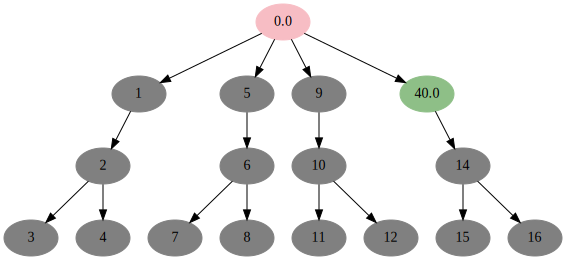

[13, 9, 5, 1, 17]


In [234]:
print("Fraction of trials in which only immediate outcomes were inspected: {}".format(np.mean(all_stems)))
print("Fraction of trials in which non-immediate outcomes were inspected before all immediate outcomes had been inspected: {}".format(np.mean(nonstem_before_stem)))


all_stems_array = np.array(all_stems)
nr_stems_array = np.array(nr_stems_inspected)
nr_nonstems_array = np.array(nr_nonstems_inspected)
np.mean(nr_stems_array[~all_stems_array])

print("Avg. number of immediate outcomes inspected when later outcomes were inspected: {}".format(np.mean(nr_stems_array[~all_stems_array])))
print("Avg. number of later outcomes inspected when any non-immediate outcomes were inspected at all: {}".format(np.mean(nr_nonstems_array[~all_stems_array])))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["decreasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

## Inspect policies for the environment with constant high variance

In [253]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"constant_high")

leaf_nodes = [3,4,7,8,11,12,15,16]
stem_nodes = [1,5,9,13]
branch_nodes = [2,6,10,14]

nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_branch_nodes_inspected = []
nr_leaf_nodes_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations = []

nr_observations_by_branch = np.empty([nr_environments,4])

e=0
for env in envs:
    trace = run_episode(LC_policies["constant_high"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_branch_nodes_inspected.append(np.sum(np.in1d(trace['actions'][:-1],branch_nodes)))
    nr_leaf_nodes_inspected.append(np.sum(np.in1d(trace['actions'][:-1],leaf_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])
    
    for b in range(len(nodes_by_branch)):
        nr_observations_by_branch[e,b]=np.sum(np.in1d(trace['actions'][:-1],nodes_by_branch[b]))
    
    
    
    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 
        
    e+=1

The average number of observations was 8.11.
0.0
0.60125
0.5945
0.41575
3.042
1.268
1.774
Example sequence: 
[10, 6, 8, 1, 14, 15, 16, 7, 9, 17]


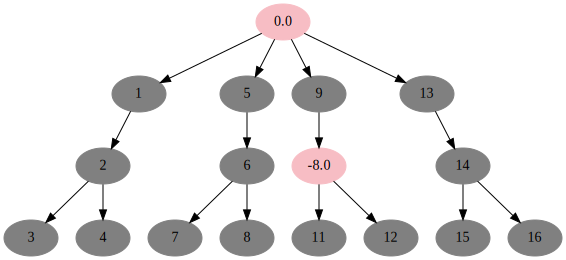

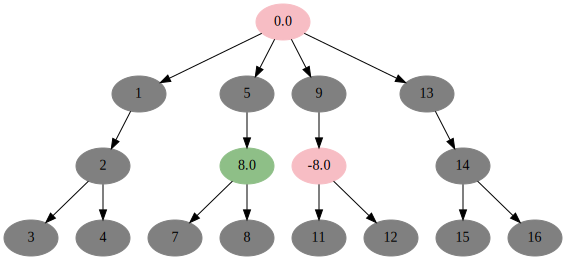

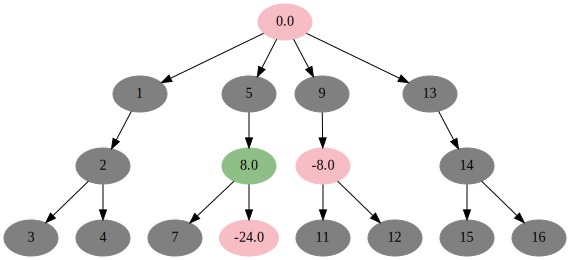

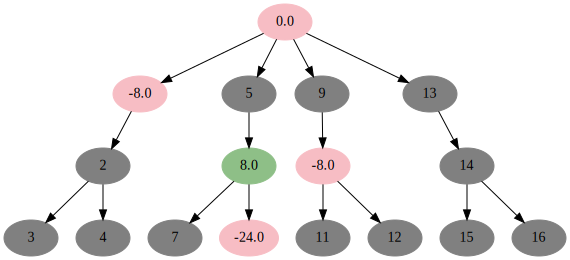

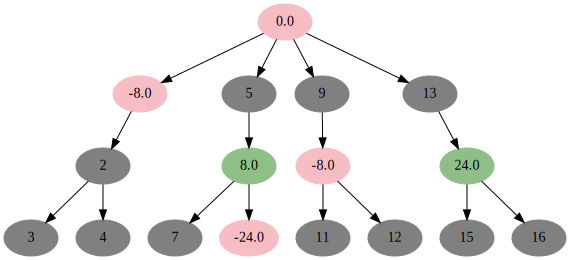

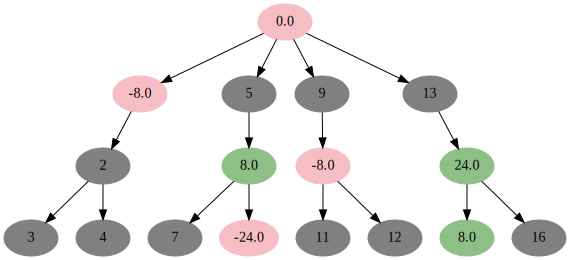

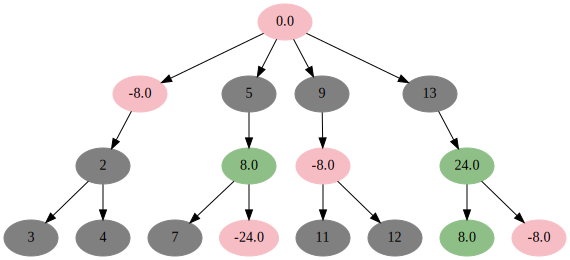

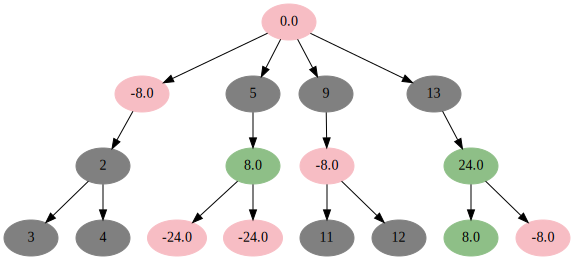

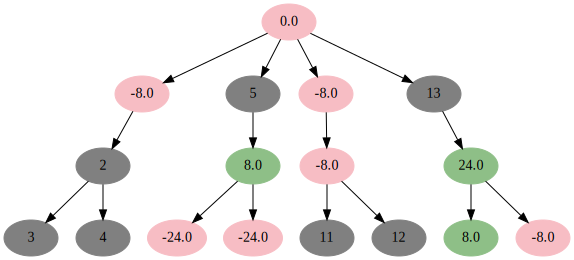

[10, 13, 16, 4, 5, 1, 17]


In [258]:
print("The average number of observations was %.2f." % np.mean(nr_observations))

print(np.mean(all_stems))
print(np.mean(nr_stems_inspected)/len(stem_nodes))
print(np.mean(nr_branch_nodes_inspected)/len(branch_nodes))
print(np.mean(nr_leaf_nodes_inspected)/len(leaf_nodes))


print(np.mean(np.amax(nr_observations_by_branch,1)))
print(np.mean(np.amin(nr_observations_by_branch,1)))
print(np.mean(np.amax(nr_observations_by_branch,1)-np.amin(nr_observations_by_branch,1)))

print("Example sequence: ")
print(trace['actions'])
env.reset()
for a in trace['actions'][0:-1]:
    trace = run_episode(LC_policies["decreasing"], envs[3])
    env.step(a)
    env.render() 

print(trace['actions']) 

## Inspect policy for the environment with constant low variance

In [239]:
nr_environments = 1000

envs = make_envs(1,nr_environments,None,"constant_low")

leaf_nodes = [3,4,7,8,11,12,15,16]
stem_nodes = [1,5,9,13]
branch_nodes = [2,6,10,14]

nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]

all_stems= []
not_all_stems=[]
nr_stems_inspected = []
nr_nonstems_inspected = []
nonstem_before_stem = []

nr_observations = []

for env in envs:
    trace = run_episode(LC_policies["constant_low"], env)
    
    nr_observations.append(len(trace['actions'])-1)
                           
    all_stems.append(np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    not_all_stems.append(not np.all(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_stems_inspected.append(np.sum(np.in1d(trace['actions'][:-1],stem_nodes)))
    nr_nonstems_inspected.append(len(trace['actions'][:-1])- nr_stems_inspected[-1])

    is_immediate = np.in1d(trace['actions'][:-1],stem_nodes)
    if all_stems[-1]:
        nonstem_before_stem.append(False)
    else:
        first_nonimmediate = np.where(is_immediate == False)
        nonstem_before_stem.append(first_nonimmediate[0][0]<len(stem_nodes)) 

In [240]:
print("The average number of observations was %.2f." % np.mean(nr_observations))

The average number of observations was 0.00.


# Measure the performance and number of clicks of the LC policies

In [265]:
from evaluation import *
from model_utils import *
from utils import *

import pandas as pd
from policies import FixedPlanPolicy
from joblib import delayed, Parallel
from tqdm import tqdm
from toolz import partition_all

term_action = 17

def eval_envs(cost, env_type, envs):
    policies = {
        'BO': LC_policies[env_type],
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'none': FixedPlanPolicy([term_action]),
    }
    def loop():
        for name, pol in policies.items():
            for _ in range(30):
                df = evaluate(pol, envs)
                df['env'] = envs
                df['agent'] = name
                df['cost'] = cost
                df['env_type'] = env_type
                yield df
    return pd.concat(loop())


envs_per_type = 100
chunks_per_job = 5
total_envs = envs_per_type * len(environments)
n_job = 26
envs_per_chunk = total_envs // (n_job * chunks_per_job)

environments=['increasing','decreasing','constant_low','constant_high']

cost = 1.00
jobs = [delayed(eval_envs)(cost, env_type, envs) 
        for env_type in environments
            for envs in partition_all(envs_per_chunk, 
                                  make_envs(cost, envs_per_cost,None, env_type))]
result = Parallel(n_job)(tqdm(jobs))

#Save results
results = pd.concat(result)
np.save('data/results_variance_structures.npy',results)

100%|██████████| 136/136 [00:08<00:00, 16.37it/s]


## Inspect the results

In [266]:
import pandas as pd

#results = np.load('data/results_variance_structures.npy')
#df = pd.DataFrame(list(results.item().iteritems()), columns=['agent','util','cost','env_type'])

#LC_policies.to_pickle('data/LC_policies_backward_planning.pkl')

#results['performance'] = results.util - results.cost*results.observations

#print(result[0].groupby(['agent','cost']).describe)

#results.agent=='BO'
#results.cost==0.1
#results[np.logical_and(results.agent=='BO',results.cost==0.1)].util.describe()

#results.groupby('agent').util.describe()
#results.groupby('cost').util.describe()
print(results.groupby(['agent','env_type']).util.mean())
print(results.groupby(['agent','env_type']).observations.mean())

results

#results.util(np.logical_and(results.agent=='BO',results.cost==0.1))

agent             env_type     
BO                constant_high    28.320000
                  constant_low      0.110000
                  decreasing       16.413200
                  increasing       22.228867
full-observation  constant_high    25.920000
                  constant_low    -13.608000
                  decreasing        6.720000
                  increasing       13.792000
none              constant_high    -1.900000
                  constant_low      0.110000
                  decreasing        1.174000
                  increasing        0.148000
Name: util, dtype: float64
agent             env_type     
BO                constant_high     8.266667
                  constant_low      0.000000
                  decreasing        3.978000
                  increasing        4.542333
full-observation  constant_high    16.000000
                  constant_low     16.000000
                  decreasing       16.000000
                  increasing       16.000000
none     

,observations,util,env,agent,cost,env_type
0,3,23.4,<MouselabEnv instance>,BO,1.0,increasing
1,4,24.0,<MouselabEnv instance>,BO,1.0,increasing
2,10,2.0,<MouselabEnv instance>,BO,1.0,increasing
0,8,18.4,<MouselabEnv instance>,BO,1.0,increasing
1,6,22.0,<MouselabEnv instance>,BO,1.0,increasing
2,10,2.0,<MouselabEnv instance>,BO,1.0,increasing
0,2,24.4,<MouselabEnv instance>,BO,1.0,increasing
1,3,25.0,<MouselabEnv instance>,BO,1.0,increasing
2,10,2.0,<MouselabEnv instance>,BO,1.0,increasing
0,5,21.4,<MouselabEnv instance>,BO,1.0,increasing
